# Spase Coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sparse_coding import SparseCodingModel
import tensorflow as tf

### Util Funcs

In [24]:
def create_images(n_samples, x_dim, y_dim):
    X = []
    for i in range(n_samples):
        img = np.zeros((x_dim, y_dim))
        x_bars = np.random.choice(np.arange(x_dim), np.random.randint(x_dim // 1.5), replace=False)
        y_bars = np.random.choice(np.arange(y_dim), np.random.randint(y_dim // 1.5), replace=False)
        y_bars = y_bars[:np.random.randint(y_dim)]
        for x in x_bars:
            img[x, :] += np.ones(y_dim)
        for y in y_bars:
            img[:, y] += np.ones(x_dim)
        img = img.reshape((x_dim * y_dim))
        X.append(img)

    return np.array(X)

In [33]:
# Gets MNIST images for a given number. (ie. if number=1, all images of 1 are returned)
def get_mnist_images(number=1):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = ((np.concatenate((x_train, x_test), axis = 0))).astype(float) 
    y = np.concatenate((y_train, y_test), axis = 0)

    if number == -1:
        digit = X
        digit = (digit.reshape((len(digit), 28*28))).astype(float)
        return digit
    # Isolate Ones
    digit = X[np.where(y == number)]
    digit = (digit.reshape((len(digit), 28*28))).astype(float)
    return digit

## Sparse Coding Model Class

### Train the Model

In [11]:
model = SparseCodingModel(256, 32, 0.001)

X_train = create_images(256, 16, 16)

model.train(X_train, num_steps=3000)

100% (3000 of 3000) |####################| Elapsed Time: 0:10:20 Time:  0:10:20


### Feature Library

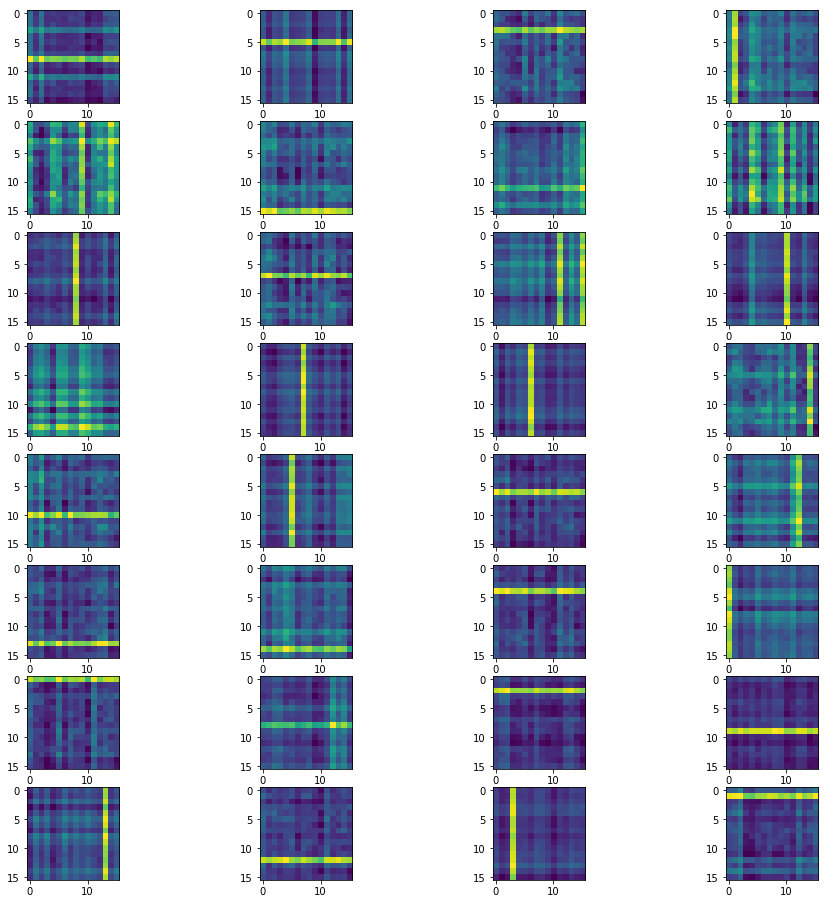

In [12]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 8
for i in range(32):
    img = model.Phi[:, i].reshape(16, 16)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

### Predict Activations From Test Images

In [13]:
X_test = create_images(10, 16, 16)
activations = model.predict(X_test, num_steps=3000)

### Generate Images From Activations

In [19]:
X_pred = model.generate(activations)

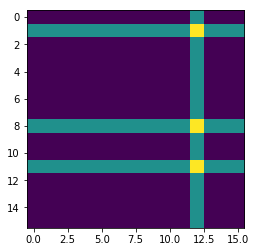

In [21]:
plt.imshow(X_test[2].reshape(16, 16))

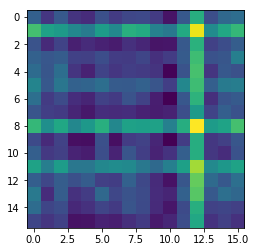

In [22]:
plt.imshow(X_pred[:, 2].reshape(16, 16))

## With Numbers

In [34]:
num_dataset = get_mnist_images(number=-1)

In [35]:
num_dataset.shape

(70000, 784)

In [36]:
num_model = SparseCodingModel(200, 64, 0.005)
num_model.train(num_dataset)

100% (2000 of 2000) |####################| Elapsed Time: 0:18:30 Time:  0:18:30


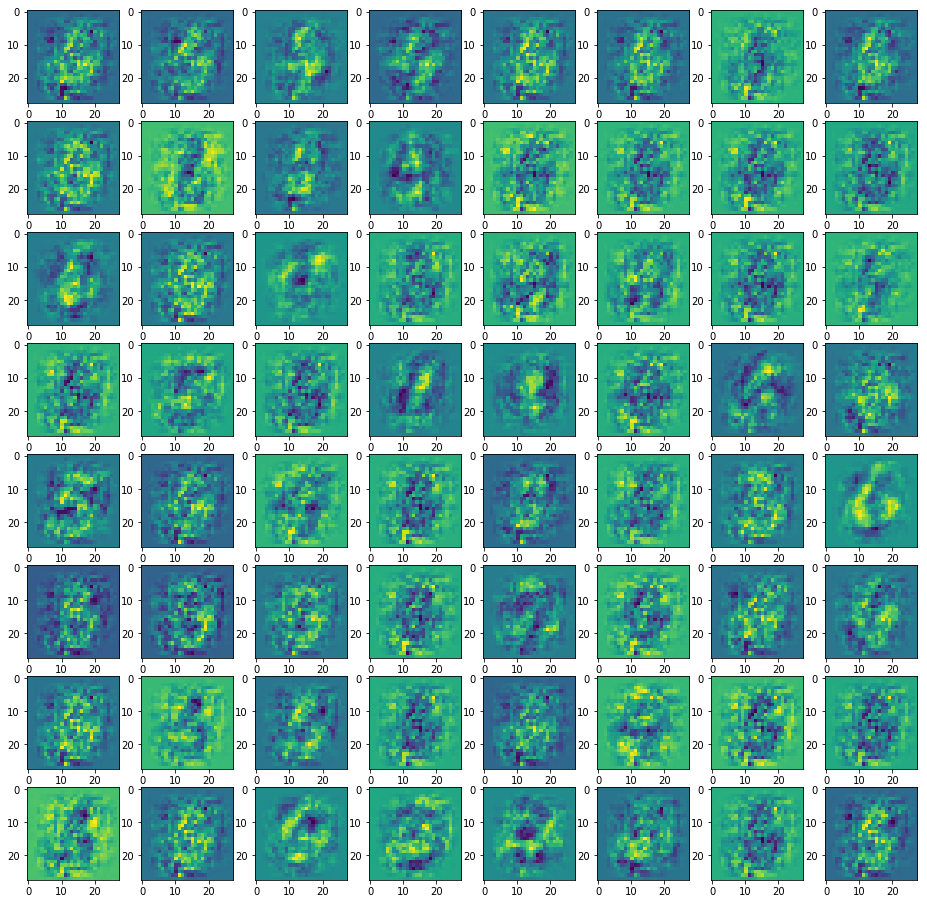

In [37]:
fig=plt.figure(figsize=(16, 16))
columns = 8
rows = 8
for i in range(64):
    img = num_model.Phi[:, i].reshape(28, 28)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

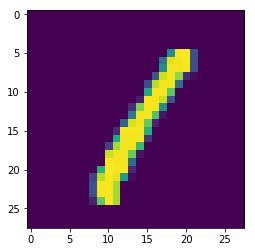

In [49]:
plt.imshow(num_dataset[3].reshape(28, 28))

In [41]:
activations = num_model.predict(num_dataset[2: 4])

In [47]:
generated_img = num_model.generate(activations[:, 1])

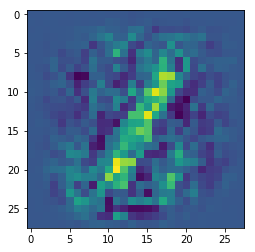

In [48]:
plt.imshow(generated_img.reshape(28, 28))

## Natural images

In [2]:
from scipy.io import loadmat

In [3]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [4]:
def load_nat_images(num_images = 400):
    n = num_images - 1
    ones_place = n % 10
    tens_place = (n // 10) % 10
    hund_place = (n // 100) % 10
    images = []
    for i in range(hund_place + 1):
        for j in range(tens_place + 1):
            for k in range(ones_place + 1):
                next_image = plt.imread("archive/natural_images/flower/flower_0%s%s%s.jpg" % (i, j, k))
                next_image = rgb2gray(next_image[:16, :16])
                next_image = next_image.reshape(16 * 16)
                images.append(next_image)
    return np.array(images)

In [5]:
def load_whitened(size=16):
    img_mat = loadmat("archive/IMAGES.mat")["IMAGES"]
    dim = int(512 // size)
    images = []
    for n in range(10):
        for i in range(dim):
            for j in range(dim):
                y_dim = i * size
                x_dim = j * size
                next_img = img_mat[x_dim:x_dim+size, y_dim:y_dim+size, n]
                images.append(next_img.reshape(size * size))
    return np.array(images)

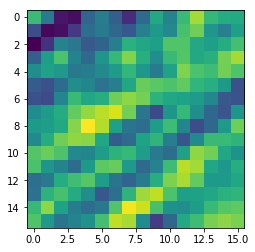

In [13]:
X = load_whitened(size=16)
plt.imshow(X[90].reshape(16, 16))

In [15]:
nat_model = SparseCodingModel(100, 128, 0.01)
nat_model.train(X, num_steps=5000)

100% (5000 of 5000) |####################| Elapsed Time: 0:45:39 Time:  0:45:39


In [16]:
def create_patchwork(Phi, x_dim, y_dim, shape):
    patchwork = np.zeros((x_dim * shape[0], y_dim * shape[1]))
    count = 0
    for i in range(x_dim):
        for j in range(y_dim):
            a = i*shape[0]
            b = j*shape[1]
            patchwork[a:a+shape[0], b:b+shape[1]] = Phi[:, count].reshape(shape[0], shape[1])
            count += 1
    return patchwork

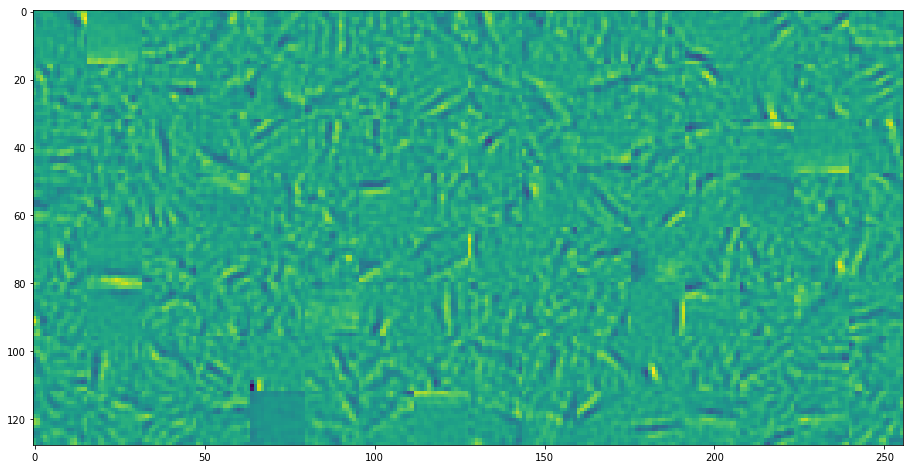

In [17]:
img = create_patchwork(nat_model.Phi, 8, 16, (16, 16))
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.savefig("natural_sparse_codes.png")

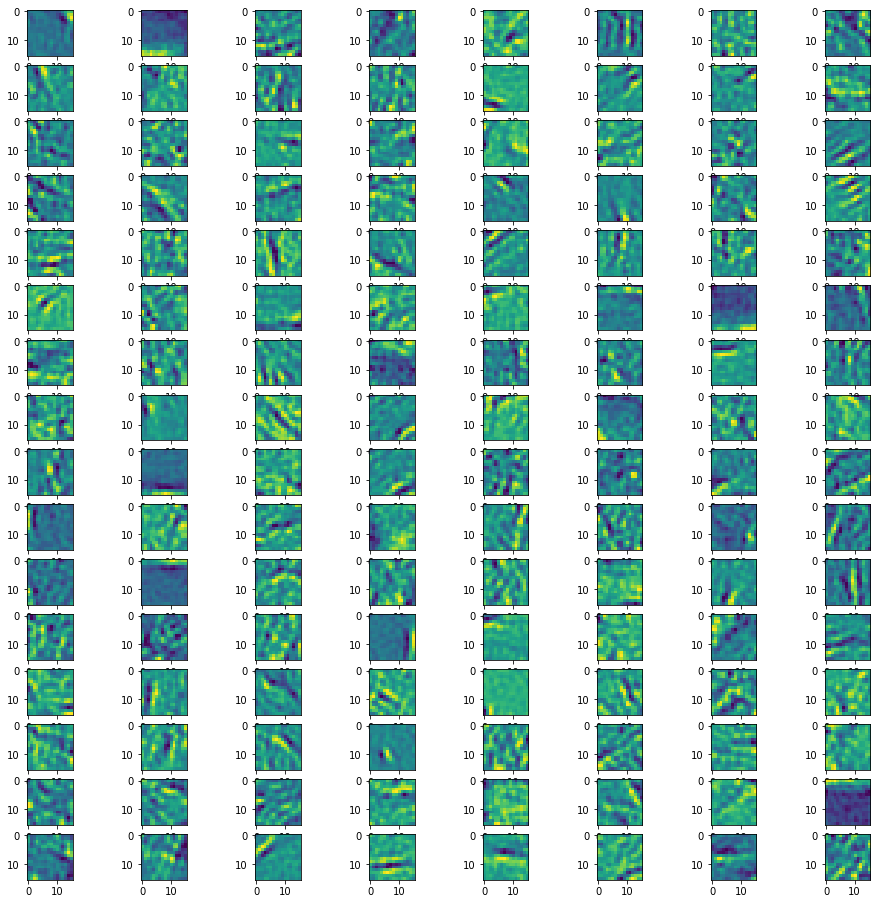

In [19]:
fig=plt.figure(figsize=(16, 16))
columns = 8
rows = 16
for i in range(128):
    img = nat_model.Phi[:, i].reshape(16, 16)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
plt.show()

In [11]:
nat_model.Phi.shape

(256, 128)